<a href="https://colab.research.google.com/github/ksokoll/LLM-Treasure-Hunt/blob/main/LLM_Treasure_Hunt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Treasure Hunt: Experiment Overview and goals

The goal of this investigation is to create a simple game of low complexity, to study how chatgpt-4o / chatgpt-4o-mini perform in different setups. Goal is a series of iterations to enhance the performance of the system. If a setup proves to improve performance, it gets taken to the next iteration.

**Base Setup** The base setup is a single LLM which receives the rules via prompt and is able to move one field at a time.

**Setup 1:** Adding a "Strategy Agent" to the loop, which should help the movement LLM find the optimal path.

**Setup 2:** Changing the prompt from moving one field at a time to a series of movements

**Setup 3** Trying different temperatures

# Experimental setup

#1. Game rules

The experimental setup is the same for each Setup.

Game Rules: The treasure hunt will take place in a 5x5 matrix. The starting point will always be [2,2], meaning that there is an equal amount of space around the starting space.

Movements are only possible orthogonally (left, right, up, down). The "treasures" will be hidden in one of four fields in one corner of the field, determined randomly.

A single game lasts until the treasure is found, or until a maximum of 24 turns is reached with a minimum amount of 2 turns to solve the task and a maximum amount of 24 turns. Since the treasure can be in 4 different fields, given the premise of knowing in which quadrant the treasure is based on a correctly solved game 1, the minimum amount of turns to solve has a expected value of 1 + (4/2), where 1 is the minimum movement to the quadrant and a 25% chance per move to hit the treasure in the target quadrant. Since game 1 is a 25% chance per quadrant and at least 8 moves have to be made with 1 turn to move to the first quadrant and 1 further turn to move to the seceond, finding the treasure in game 1 has a expected value of 10 turns.

Therefore the expected values for the trials are:
[10, 3, 3, 3, 3, 3, 3, 3, 3, 3]
with a average of 3,7.

A "trial" is a sequence of 10 consecutive games. In game 1 there will be no clues about past treasure locations. Beginning from the first found treasure, the LLM will receive hints about past treasure location to enable knownedge transfer.

# Experimental Process

For each setup 10 trials will be conducted, which means there will be 100 games with 10 eliminations of the knowledge database. The reason is to flatten out variance over the course of the trial.

# Prompt Generation

The starting prompt was written and iteratively improved by chatgpt 4o over the course of 1000 games. It will stay almost the same for the whole experiment, with slight adjustment for a different movement setup.



# Summary of the results

Summary of the results

The experiment provided some interesting insights into how LLMs behave when confronted with the task of independently recognizing patterns and efficiently solving a task of easy complexity.

Here are the findings:

1. Without additional adaptations, the LLM hardly performed better than if the maze had been solved randomly, even though the prompt was automatically iteratively improved before the experiment started.

2. The LLM could not work optimally if a separate API call was triggered for each individual step. Instead, performance improved greatly when it was allowed to plan several moves in advance. This could indicate that the larger context window allowed it to plan more intelligently.

3. Using a supporting LLM to help the move_agent with planning did not prove helpful. Performance improved greatly when the LLM was left to its own devices and was only told the last successful coordinates. This may indicate that for simple problems such as this one, it may be more effective not to include too many LLMs in the loop, as they hinder rather than support each other.

4. No correlation was found between changes in temperature and the models performance in this task.

---

# 1. Init

In [ ]:
!pip install python-dotenv
!pip install instructor
!pip install httpx==0.23.0
!pip install --upgrade openai

In [ ]:
from google.colab import files
from google.colab import userdata
from dotenv import load_dotenv
import os
from enum import Enum
from pydantic import BaseModel, Field
import instructor
from openai import OpenAI
import openai
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
# API Key

key = userdata.get('OpenAIKey')

with open(".env", "w") as f:
    f.write(
        f"OPENAI_API_KEY='{key}'\n"
    )

# Load environment variable
load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")

In [ ]:
client = instructor.from_openai(OpenAI())

# 2. Define Movement Functions

In [ ]:
class movement(str, Enum):
  left = "left",
  right = "right",
  up = "up",
  down = "down"

In [ ]:
grid_size = 5

In [ ]:
temperature = 0.7

In [ ]:
def update_matrix(matrix, position):
    # Mark the current position as visited
    matrix[position[0], position[1]] = 1
    return matrix

In [ ]:
def matrix_to_string(matrix):
    return "\n".join([" ".join(map(str, row)) for row in matrix])

In [ ]:
def llm_movement(query: str, position, tried_positions: str, llm_strategy_hint: str, tried_positions_matrix, verbose):
  query = query + f"Strategy Hint: {llm_strategy_hint};\n Current position: {position};\n Already tried positions: \n{tried_positions}"
  if verbose == 1:
    print(query)
  try:
        reply = client.chat.completions.create(
            model="gpt-4o-mini",
            response_model=Reply,
            temperature = temperature,
            max_retries=3,
            messages=[
                {
                    "role": "system",
                    "content": systemPrompt
                },
                {
                    "role": "user",
                    "content": query
                }
            ]
        )
        return reply.category.name
  except Exception as e:
        return f"Error: {str(e)}"

In [ ]:
def move(direction, position):
    if direction == "down" and position[0] < 4:  # Raise Y Coordinate, when going up
        position[0] += 1
    elif direction == "up" and position[0] > 0:  # Decrease Y Coordinate, when moving down
        position[0] -= 1
    elif direction == "left" and position[1] > 0:  # Decrease X Coordinate when moving left
        position[1] -= 1
    elif direction == "right" and position[1] < 4:  # Increase X Coordinate when moving right
        position[1] += 1
    return position

In [ ]:
def generate_random_treasure_position(quarter):
    if quarter == 0:  # Upper left
        x = random.randint(0, 1)
        y = random.randint(0, 1)
    elif quarter == 1:  # Upper Right
        x = random.randint(3, 4)
        y = random.randint(0, 1)
    elif quarter == 2:  # Bottom Left
        x = random.randint(0, 1)
        y = random.randint(3, 4)
    elif quarter == 3:  # Bottom Right
        x = random.randint(3, 4)
        y = random.randint(3, 4)

    return [x, y]

# 3. Create Agents and System Prompts

In [ ]:
class Reply(BaseModel):
  content: str = Field(description="The answer to the query")
  category: movement = Field(description="Correctly assign to the predefined movements.")

In [ ]:
systemPrompt = """
Your task is to effectively navigate a matrix to uncover a hidden treasure in a treasure hunt game.

"0" indicates unvisited fields, and "1" indicates visited fields. A treasure is hidden in one of these fields. The fields are numbered like a Python matrix, from 0,0 (top left) to 4,4 (bottom right).

You start from a defined position with a clue regarding past treasure locations. Your goal is to locate the treasure by recognizing and following the established pattern.

Instructions:

- Name a movement based on patterns from previous treasures to find the current treasure.
- Ensure the movement is contributing a logical sequence of orthogonal movements.
- Plan your moves one at a time. After each move, update the matrix and evaluate the next step based on the updated state. Continue until the moves are completed.

Priorities (in order of importance):
1. Avoid visiting fields which are marked with "1".
1. Take the fastest path to reach the estimated treasure location based on past treasure locations.
2. Respect matrix boundaries.

Output your solution as a single movement, such as ["down", "down", "right", ...]. Avoid any extra comments or explanations.

"""

In [ ]:
systemPrompt3 = f"""
You are a strategy agent in a treasure hunting game.

  Task: Analyze the already visited fields and use the knowledge-database and give a hint to the move_agent, which direcetion would be most appropriate to move to.

  Rules: Your movement is restricted within a 5x5 grid, with positions ranging from [x=0,y=0] (top-left) to [x=4,y=4] (bottom-right). You can only move one field at a time.
  Moving Down will increase the X value of the current position vice versa, moving right will increase the y value of the current position, vice versa.
  Never advise to move in a direction not stated in 'Possible Directions'.

  The grid showing visited (1) and unvisited (0) positions is below.

  """

In [ ]:
def llm_strategist(knowledge_database_answer: str, tried_positions_matrix, current_position):
  query3 = f"""
  Tried positions: {tried_positions_matrix},\n
  Knowledge Database: {knowledge_database_answer},\n
  Current Position: {current_position}
  """

  reply = client.chat.completions.create(
            model="gpt-4o-mini",
            response_model=Reply,
            temperature = temperature,
            max_retries=3,
            messages=[
                {
                    "role": "system",
                    "content": systemPrompt3
                },
                {
                    "role": "user",
                    "content": query3
                }
            ]
        )
  return reply.content


In [ ]:
class Reply2(BaseModel):
  content: str = Field(description="The answer to the query")

# 4. Define Turn Function

In [ ]:
def turn(tried_positions_matrix, position, knowledge_database, verbose):

    # Conversion of the matrix into a character string
    matrix_str = matrix_to_string(tried_positions_matrix)

    # Strategy Agent
    llm_strategy_hint = llm_strategist(knowledge_database, tried_positions_matrix, position)
    #print(f"LLM Strategy Hint: {llm_strategy_hint}")

    # LLM Movement
    llm_order_counts = []
    for _ in range(1):
      llm_order = llm_movement("Which direction to go?; ",position, matrix_str, llm_strategy_hint, tried_positions_matrix, verbose)
      llm_order_counts.append(llm_order)
    if verbose == 1:
      print(llm_order_counts)
    llm_order = max(llm_order_counts, key=llm_order_counts.count)

    # Move
    new_position = move(llm_order, position)

    # Update Matrix
    tried_positions_matrix = update_matrix(tried_positions_matrix, position)

    return tried_positions_matrix, new_position


#5. Treasure Hunt Loop

In [ ]:
# Level 1: Trials
def trial(trial_iterations, verbose):
  # Epoch Starting Variables
  iterations = trial_iterations
  history_overall = []
  knowledge_database = ""
  attempt_history = []
  quarter= random.randint(0,3)

  # Level 2: Iterations
  for iteration, _ in enumerate(range(iterations)):
      treasure_history = []
      turn_history = 0
      attempts = 24
      starting_position = [2,2] # Startposition

      # Create random treasure:
      position = starting_position
      treasure = generate_random_treasure_position(quarter)

      # Create a new treasure if it is on starting position to avoid insta-win
      while treasure == [2,2]:
        treasure = generate_random_treasure_position(quarter)


      print(f"Iteration {iteration}, Treasure Location: {treasure}")
      # Initialisierung der Matrix und Position
      tried_positions_matrix = np.zeros((grid_size, grid_size), dtype=int)  # Matrix initialisieren
      tried_positions_matrix[2, 2] = 1 # Setze das erste Feld auf besucht

      # Level 3: Steps
      for index, _ in enumerate(range(attempts), start=1):


        # Take turn:
        tried_positions_matrix, position = turn(tried_positions_matrix, position, knowledge_database, verbose)
        if position == treasure:
          print(f"You found the treasure after {index} movements at position {position}")
          treasure_hunt = f"Treasure Position: {position}; Movements: {index}"
          treasure_history.append(treasure_hunt)
          turn_history = turn_history+index
          break

      attempt_history.append(index)

      history_overall.append(f"Run {iteration} Treasure History: {treasure_history} ; Run {iteration} Turn-History: {turn_history}; Run {iteration} Knowledge Database: {knowledge_database}")

      knowledge_database = history_overall



  return attempt_history

---

# 6. Evaluation Trials

# Baseline Trials to determine the random turns to solve the task

In [ ]:
def turn_baseline(tried_positions_matrix, position):
    # Conversion of the matrix into a character string
    matrix_str = matrix_to_string(tried_positions_matrix)

    # Strategy Agent
    print(f"LLM Strategy Hint: {llm_strategy_hint}")

    # LLM Input
    llm_order = random.choice(list(movement)).value
    #print(f"LLM Order: {llm_order}")

    # Movement
    new_position = move(llm_order, position)

    # Update Matrix
    tried_positions_matrix = update_matrix(tried_positions_matrix, position)

    return tried_positions_matrix, new_position


In [ ]:
# Level 1: Trials
def trial_baseline(trial_iterations):
  # Epoch Starting Variables
  iterations = trial_iterations
  history_overall = []
  knowledge_database = ""
  attempt_history = []
  quarter= random.randint(0,3)

  # Level 2: Iterations
  for iteration, _ in enumerate(range(iterations)):
      treasure_history = []
      turn_history = 0
      attempts = 24
      starting_position = [2,2] # Startposition

      # Create random treasure:
      position = starting_position
      treasure = generate_random_treasure_position(quarter)

      # Create a new treasure if it is on starting position to avoid insta-win
      while treasure == [2,2]:
        treasure = generate_random_treasure_position(quarter)


      print(f"Iteration {iteration}, Treasure Location: {treasure}")
      # Initialisierung der Matrix und Position
      tried_positions_matrix = np.zeros((grid_size, grid_size), dtype=int)
      tried_positions_matrix[2, 2] = 1 # Set first field as visited

      # Level 3: Steps
      for index, _ in enumerate(range(attempts), start=1):

        # Take turn:
        tried_positions_matrix, position = turn_baseline(tried_positions_matrix, position)
        if position == treasure:
          treasure_hunt = f"Treasure Position: {position}; Movements: {index}"
          treasure_history.append(treasure_hunt)
          turn_history = turn_history+index
          break

        elif index == attempts:
          turn_history = turn_history+index
          treasure_hunt = f"Failed to find Treasure due to maximum movements; Movements: {index}"
          treasure_history.append(treasure_hunt)
          break

      attempt_history.append(index)

      history_overall.append(f"Run {iteration} Treasure History: {treasure_history} ; Run {iteration} Turn-History: {turn_history}; Run {iteration} Knowledge Database: {knowledge_database}")


  return attempt_history

In [ ]:
baseline_trial_history = []
iterations = 1000
trials = 300

for _ in range(trials):
  print(f"Trial {_}:")
  baseline_trial_history.append(trial_baseline(10))
  print(f"\n{baseline_trial_history}")

In [ ]:
def calculate_row_averages(matrix):
    averages = []
    for row in matrix:
        row_average = sum(row) / len(row)
        averages.append(row_average)
    return averages

In [ ]:
def calculate_list_average(values):
    if not values:
        return 0
    return sum(values) / len(values)

In [ ]:
calculate_list_average(calculate_row_averages(baseline_trial_history))

19.340666666666667

Turns needed to solve the task randomly:
**19.34**

This value will serve as a base line for the performance of the agentic system. If it can reliably and repeatedly solve the task below these turns, it can be viewed as working.

#Trial Loop Replication and Setup 1: Basic Setup

The result of each trial (10 games) will vary even when no parameters are changed.
Goal of this chapter is to measure how many trials of 10 games are necessary to get a stable and reproducable result so we minimize variance as a factor.

This test is also conducted with Setup 1: The strategy agent, to test the performance.

*H0: The move_agent in combination with the strategy_agent perform equally good or worse than the random solving of the task in 19,34 turns.*

*H1: The move_agent in combination with the strategy_agent performs at least 7,5% better than randomly solving the task*

In [ ]:
trial_history = []
trial_averages = []
iterations = 10
trials = 20
verbose = 0 # 0 = off, 1 shows detailed progress on Step Level

# The temperatures to be tested:
temperature_scale = [0.7]

for degree in temperature_scale:
  temperature = degree
  trial_history.append(degree)
  trial_averages.append(degree)

  for _ in range(trials):
    print(f"Trial {_}:, \nTemperature: {degree}")
    trial_history.append(trial(iterations, verbose))
    print(f"\n{trial_history}")


In [ ]:
# 10 trials:
[0.7, [24, 24, 24, 16, 9, 2, 24, 24, 3, 16], [24, 24, 8, 24, 6, 4, 4, 3, 3, 14], [12, 5, 2, 5, 10, 7, 2, 24, 6, 4], [24, 24, 24, 24, 24, 24, 24, 24, 24, 24], [24, 24, 24, 24, 24, 24, 24, 24, 24, 24], [24, 15, 11, 24, 24, 2, 24, 24, 24, 5], [21, 13, 2, 2, 24, 11, 24, 14, 24, 24], [24, 24, 24, 24, 24, 22, 24, 7, 24, 4], [24, 24, 24, 24, 2, 24, 13, 24, 24, 24], [9, 21, 8, 10, 2, 8, 11, 5, 3, 4]]
# 20 more trials:
[0.7, [24, 12, 24, 24, 3, 24, 24, 24, 24, 5], [5, 19, 4, 4, 3, 4, 9, 5, 11, 6], [24, 24, 11, 7, 13, 24, 17, 5, 14, 5], [24, 24, 24, 24, 24, 24, 12, 9, 12, 5], [24, 24, 24, 24, 24, 24, 24, 24, 24, 24], [24, 24, 24, 24, 24, 24, 24, 24, 24, 14], [24, 24, 24, 24, 24, 24, 24, 24, 24, 24], [8, 14, 24, 24, 3, 24, 24, 24, 24, 3], [17, 4, 3, 2, 3, 23, 2, 24, 2, 3], [24, 24, 24, 24, 4, 2, 23, 2, 11, 24], [6, 15, 11, 8, 3, 19, 4, 3, 3, 5], [24, 24, 24, 24, 24, 24, 24, 24, 24, 24], [4, 6, 21, 24, 21, 7, 5, 24, 5, 24], [24, 24, 24, 24, 24, 24, 24, 24, 24, 24], [4, 24, 24, 2, 24, 3, 11, 9, 7, 24], [24, 20, 2, 4, 6, 11, 5, 3, 23, 3], [24, 24, 24, 24, 24, 24, 24, 24, 24, 24], [24, 24, 24, 24, 24, 10, 24, 24, 4, 24], [18, 2, 2, 24, 24, 2, 24, 24, 24, 6], [12, 24, 24, 2, 24, 24, 24, 24, 24, 24]]

# Results Setup 1

Results from the test:
Average in run 1: 18,14
Average in run 2: 18,87
Average in run 3: 19,5

Average across all 3 runs: 18,84

The volatility between the single tests are 7,5% percentage difference, which is moderate and shows a general consistency in the measurements. For the following evaluations, a set of 10 trials over 10 games is performed. However, to exclude performance gains/losses by chance, the 7,5% mark has to be beaten by future adjustments of the systems.

The combination of the LLM moving exactely 1 field per call and the strategy-agent helping the move_agent showed a slightly better performance than the random solving of the tasks. (18,84 in comparison to 19,34 turns randomly.

The performance gain of 2,58% is however below the volatility threshold of 7,5% set earlier, so the performance gain cannot be attributed to the LLMs.

*H0 gets accepted.*
*H1 gets rejected*

# Setup 2: Optimizing the prompt and movement functions

Until now the model took single steps with each call, which may lead to:
- Inefficient Path generation: Though the previous visited coordinates are delivered with each call, resetting the context window with each movement could lead to less efficient route planning.
- Inefficient resource use: It took about 10 steps to solve the task, which is not resource efficient
- Cumulation of mistakes: With each single step, a mistake cascaded to the next steps. Multiple calls therefore could have increased errors made by the LLM.

Idea:
Instead of single steps, the LLM should now propose a complete path to a target coordinate, with the same rules as above. This might lead to more coherent and better route planning.

Strategy Agent: This agent might be of more help since the move_agent can now plan multiple turns in advance.

Therefore the Setup 2 is: Strategy_agent stays, movement of the move_agent is enhanced to a series of movements determinated by the move_agent.

*H0(2): Giving the move_agent the possibility to output multiple turns will result in a equally or worse performance of the previous setup (18,84)*

*H1(2): The move_agent in combination with the new movement pattern performs at least 7,5% better than the the previous setup*


In [ ]:
import re
from typing import List

# Instructor will make sure to receive only
class PathSchema(str):
    Coordinates: List[str]

Rewrite Turn function:

In [ ]:
class Reply_2(BaseModel):
  content: str = Field(description="The answer to the query")

In [ ]:
# Level 1: Trials
def trial_2(trial_iterations, verbose):
  # Epoch Starting Variables
  iterations = trial_iterations
  history_overall = []
  knowledge_database = ""
  attempt_history = []
  quarter= random.randint(0,3)

  # Level 2: Iterations
  for iteration, _ in enumerate(range(iterations)):
      treasure_history = []
      turn_history = 0
      attempts = 24
      starting_position = [2,2] # Startposition

      # Create random treasure:
      position = starting_position
      treasure = generate_random_treasure_position(quarter)

      # Create a new treasure if it is on starting position to avoid insta-win
      while treasure == [2,2]:
        treasure = generate_random_treasure_position(quarter)


      #print(f"Iteration {iteration}, Treasure Location: {treasure}")
      # Initialisierung der Matrix und Position
      tried_positions_matrix = np.zeros((grid_size, grid_size), dtype=int)
      tried_positions_matrix[2, 2] = 1 # Set first field to visited

      dead_end = False

      treasure_found = False

      # Level 3: Steps
      for index, _ in enumerate(range(attempts), start=1):

        #print(knowledge_database)

        # Before move call, check for game win
        if treasure_found:
          #print(f"You found the treasure after {index} movements at position {position}")
          treasure_hunt = f"Treasure Position: {position}; Movements: {index}"
          treasure_history.append(treasure_hunt)
          #print(treasure_hunt)
          turn_history = turn_history+index
          knowledge_database = knowledge_database + f"{position},"
          break

        # Strategy Agent
        #llm_strategy_hint = llm_strategist(knowledge_database, tried_positions_matrix, position)
        llm_strategy_hint = knowledge_database

        llm_order = llm_movement("Which path to go?; ",position, llm_strategy_hint, tried_positions_matrix, verbose)

        if verbose == 1:
          print(llm_order)

        # Bewegung durchführen
        pattern = r"\b(up|down|left|right)\b"
        matches = re.findall(pattern, llm_order)

        for movement in matches:
            # If movements left, take turn:
            tried_positions_matrix, position = turn_2(movement, tried_positions_matrix, position, knowledge_database, verbose)
            if position == treasure:
              treasure_found = True
              break

      attempt_history.append(index)

      history_overall.append(f"Run {iteration} Treasure History: {treasure_history} ; Run {iteration} Turn-History: {turn_history}; Run {iteration} Knowledge Database: {knowledge_database}")


  return attempt_history

In [ ]:
systemPrompt_2 = """
Task:
Your task is to suggest a route that will lead you to your destination in a treasure hunt game.

Imagine a matrix that looks something like this:

00000
00100
00000

Where “0” represents unvisited fields and “1” represents visited fields. A treasure is hidden in one of the fields.
The fields are numbered like a python matrix, from 0,0 (top left) to 4,4 (bottom right).

You start at a given position, a hint where previous treasures have been found, and your goal is to find the treasure at its hidden location, which is following this pattern.

Please suggest a series of movements based on the pattern derived from previous found treasures (using "up", "down", "left", "right") that will take you from your current position to the treasure, avoiding visited fields marked as "1".

Please notice:

It is important that the movements form a complete path, meaning you should suggest a sequence of orthogonal movements (not just a single step) to reach the destination.

Your answer should be a list of movements, e.g., ["down", "down", "right", "right"]. No further comments or explanations.

Make sure the movements respect the matrix boundaries and avoid revisiting previously visited fields.

"""

In [ ]:
def llm_movement(query: str, position, llm_strategy_hint: str, tried_positions_matrix, verbose):

  position_tuple = tuple(position)  # Convert the list into a tuple

  # Generate the movement directions based on the current position and the matrix

  query = query + f"Locations of past treasures: {llm_strategy_hint};\n Current position: {position}; Tried positions: \n{tried_positions_matrix})"
  if verbose == 1:
    print(query)
  try:
        reply = client.chat.completions.create(
            model="gpt-4o-mini",
            response_model=Reply_2,
            temperature = temperature,
            max_retries=3,
            messages=[
                {
                    "role": "system",
                    "content": systemPrompt_2
                },
                {
                    "role": "user",
                    "content": query
                }
            ]
        )
        #print(f"LLM Movement Thoughts: {reply.content}")
        return reply.content
  except Exception as e:
        return f"Error: {str(e)}"

In [ ]:
def turn_2(movement, tried_positions_matrix, position, knowledge_database, verbose):

  new_position = position
  new_position = move(movement, position)
  #print(f"New Position: {new_position}")

  # Update Matrix
  tried_positions_matrix = update_matrix(tried_positions_matrix, position)

  return tried_positions_matrix, new_position


In [ ]:
trial_history = []
trial_averages = []
iterations = 10
trials = 10
verbose = 0 # 0 = off, 1 shows detailed progress on Step Level

# The temperatures to be tested:
temperature_scale = [1.5]

for degree in temperature_scale:
  temperature = degree
  trial_history.append(degree)
  trial_averages.append(degree)

  for _ in range(trials):
    print(f"Trial {_}:, \nTemperature: {degree}")
    trial_history.append(trial_2(iterations, verbose))
    print(f"\n{trial_history}")


In [ ]:
# Setup 2: [0.7, [24, 2, 24, 24, 24, 22, 24, 24, 24, 24], [2, 3, 6, 10, 13, 5, 8, 18, 3, 6], [16, 5, 4, 2, 13, 8, 4, 4, 11, 19], [13, 19, 3, 4, 2, 9, 6, 24, 22, 8], [10, 24, 2, 24, 10, 24, 16, 11, 22, 13], [24, 10, 5, 21, 24, 7, 4, 10, 17, 9], [3, 22, 24, 10, 19, 24, 2, 2, 2, 7], [5, 9, 5, 24, 21, 24, 21, 22, 7, 12], [8, 9, 7, 2, 24, 14, 19, 17, 24, 5], [4, 7, 15, 18, 3, 24, 10, 6, 2, 5]]

# Results Setup 2:

Average turns: 12,84

The change of the output of the move_agent seemed to have a high impact on the ability of the LLM to solve the task. A reason might be that the LLM can process a more complex path and apply better reasoning when it can plan through multiple steps, and follow the advise of the strategy_agent better.

# Setup 3: Extending the movements in the context window

Instead of the strategy_agent the move_agent will only receive a list of the positions of previously found treasures. Since this task is relatively simple, too many LLMs could interfere each other rather then enhancing.

H0(3): Replacing the strategy_agent with the history of previous found treasures will result in an equal or worse performance than the average turns of Setup 2 (12,84).

H1(3): The replacement will lead to a at least 7,5% better performance then with the strategy_agenet

In [ ]:
# Results with Setup 3:
[0.7, [14, 4, 7, 6, 7, 5, 4, 7, 5, 2], [5, 5, 10, 5, 2, 2, 10, 7, 3, 3], [13, 2, 12, 5, 5, 8, 6, 4, 13, 2], [3, 10, 4, 2, 2, 4, 5, 6, 2, 2], [4, 2, 10, 2, 2, 5, 2, 2, 2, 5], [7, 2, 3, 4, 14, 5, 2, 2, 2, 2], [3, 5, 2, 5, 4, 3, 2, 9, 6, 5], [19, 6, 2, 8, 19, 6, 3, 2, 3, 2], [4, 2, 4, 9, 2, 5, 2, 2, 2, 14], [2, 2, 2, 2, 4, 2, 5, 3, 2, 4]]

# Results Setup 3:

Average turns: 4,76

The LLM could solve the task in 4,76 turns on average. Thats a massive performance boost in comparison to the 12,84 turns of the previous setup (62,93% better performance) and even 75,38% better than solving the task at random.
What stands out is that there is not a single game with 24 turns, meaning the LLM did follow the instructions in the prompt as well as the previous treasure locations reliably.

Also 4,76 is relatively near to the minimum amount of turns possible which is 3,7.

H0(3) gets rejected.

# Setup 4: Measuring performance under different temperatures

The results at temperature 0.7 are already good. Since the task takes some creativity to solve, the assumption lies near that warmer temperatures result in a better performance than the colder ones.

H0(4): Temperatures > 0.7 average in a equally good or worse performance than the average values <= 0.7.

H1(4): There a performance increase of at lease 7,5% in the performance of the model when using temperature  > 7. comparing to the average temperatures of <= 0,7.

In [ ]:
Setup 4:
[0, [24, 4, 2, 3, 2, 24, 3, 3, 4, 3], [19, 2, 4, 2, 2, 4, 13, 3, 2, 2], [3, 2, 7, 2, 2, 2, 3, 2, 3, 6], [24, 5, 6, 2, 2, 3, 2, 2, 2, 2], [3, 2, 3, 3, 2, 3, 2, 2, 2, 2], [6, 2, 2, 2, 2, 2, 6, 8, 2, 2], [4, 2, 2, 3, 4, 3, 3, 18, 4, 7], [3, 2, 2, 2, 3, 2, 2, 2, 2, 2], [3, 2, 2, 3, 2, 5, 4, 2, 2, 2], [5, 2, 3, 2, 2, 3, 2, 2, 2, 2], 0.1, [24, 19, 4, 22, 4, 3, 4, 8, 3, 3], [2, 9, 2, 8, 2, 3, 2, 2, 2, 3], [4, 3, 3, 11, 3, 9, 2, 2, 3, 4], [2, 3, 2, 2, 3, 24, 3, 2, 3, 2], [3, 2, 4, 6, 2, 7, 18, 3, 2, 2], [24, 20, 2, 12, 5, 10, 15, 4, 6, 4], [5, 7, 2, 3, 2, 2, 2, 2, 5, 2], [4, 2, 24, 5, 24, 14, 2, 3, 2, 2], [3, 4, 7, 2, 2, 24, 24, 2, 5, 2], [12, 2, 4, 2, 24, 2, 20, 3, 20, 3], 0.2, [8, 15, 2, 5, 2, 2, 2, 3, 2, 2], [6, 5, 3, 2, 3, 6, 2, 3, 2, 2], [8, 2, 2, 15, 5, 3, 4, 23, 4, 24], [24, 12, 5, 6, 2, 2, 2, 2, 2, 3], [5, 10, 2, 2, 2, 5, 2, 2, 2, 2], [5, 3, 2, 3, 2, 2, 3, 2, 2, 8], [3, 3, 2, 3, 3, 8, 2, 2, 2, 2], [15, 2, 2, 3, 5, 2, 4, 2, 2, 2], [4, 2, 14, 9, 2, 2, 5, 2, 3, 8], [11, 2, 4, 3, 2, 3, 7, 2, 2, 3], 0.3, [13, 6, 3, 7, 2, 3, 6, 4, 2, 4], [3, 6, 2, 2, 2, 3, 3, 5, 5, 2], [2, 2, 2, 4, 6, 2, 2, 3, 2, 2], [6, 4, 2, 2, 2, 3, 2, 2, 2, 2], [7, 3, 2, 2, 2, 2, 3, 2, 2, 6], [24, 12, 4, 8, 2, 2, 11, 2, 2, 2], [3, 3, 2, 2, 2, 2, 2, 2, 2, 3], [3, 2, 2, 2, 8, 3, 2, 9, 2, 2], [3, 8, 9, 3, 6, 2, 2, 2, 7, 2], [6, 2, 2, 2, 2, 3, 2, 3, 2, 2], 0.4, [21, 3, 7, 4, 2, 3, 2, 2, 3, 5], [2, 2, 3, 2, 3, 2, 2, 2, 2, 2], [2, 4, 2, 7, 2, 2, 2, 2, 5, 5], [24, 24, 2, 3, 2, 3, 4, 2, 2, 3], [4, 2, 3, 6, 6, 8, 12, 3, 3, 4], [6, 5, 5, 2, 6, 2, 5, 2, 3, 5], [2, 2, 2, 2, 3, 3, 3, 2, 2, 2], [3, 2, 2, 3, 4, 2, 4, 2, 3, 4], [24, 7, 2, 7, 8, 24, 5, 4, 4, 4], [7, 3, 2, 2, 2, 10, 4, 2, 2, 2], 0.5, [6, 24, 2, 2, 8, 5, 3, 6, 2, 5], [2, 2, 2, 6, 2, 3, 2, 9, 2, 10], [2, 2, 2, 2, 3, 4, 24, 2, 3, 2], [9, 8, 10, 2, 8, 2, 4, 7, 7, 2], [2, 2, 6, 2, 5, 4, 2, 2, 6, 4], [3, 14, 2, 2, 6, 2, 5, 5, 2, 2], [3, 2, 2, 2, 2, 4, 2, 2, 2, 3], [4, 20, 17, 24, 2, 15, 5, 3, 2, 2], [3, 4, 2, 24, 6, 3, 5, 24, 6, 2], [7, 6, 2, 7, 2, 2, 2, 11, 3, 2], 0.6, [24, 6, 4, 11, 2, 3, 10, 2, 4, 2], [2, 8, 4, 2, 4, 2, 3, 2, 2, 2], [24, 24, 24, 6, 2, 2, 3, 2, 2, 2], [11, 11, 15, 2, 2, 3, 2, 3, 3, 7], [3, 4, 2, 2, 2, 5, 2, 2, 2, 2], [6, 3, 2, 2, 2, 2, 2, 5, 3, 2], [5, 4, 6, 2, 2, 2, 3, 5, 2, 5], [7, 3, 24, 5, 2, 4, 2, 2, 2, 2], [24, 4, 2, 12, 2, 2, 2, 2, 2, 2], [7, 6, 3, 8, 4, 3, 2, 2, 2, 2], 0.7, [2, 2, 3, 3, 9, 2, 3, 6, 2, 3], [4, 6, 2, 2, 5, 4, 2, 3, 15, 2], [8, 3, 3, 3, 5, 3, 4, 3, 2, 2], [24, 5, 2, 2, 12, 16, 24, 3, 6, 9], [3, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 4, 20, 2, 2, 4, 7], [14, 11, 5, 2, 4, 2, 4, 2, 4, 2], [4, 6, 3, 2, 3, 2, 5, 6, 2, 2], [3, 8, 3, 3, 3, 5, 2, 5, 2, 3], [10, 2, 2, 2, 3, 2, 3, 5, 2, 2], 0.8, [4, 5, 6, 6, 2, 4, 5, 2, 7, 2], [7, 2, 3, 5, 2, 3, 2, 2, 6, 5], [24, 4, 13, 5, 12, 20, 9, 5, 5, 9], [3, 2, 3, 2, 5, 2, 3, 2, 2, 2], [3, 2, 2, 4, 2, 5, 2, 3, 2, 2], [3, 3, 2, 2, 3, 4, 3, 8, 2, 6], [5, 2, 7, 5, 2, 8, 24, 20, 2, 2], [8, 7, 2, 2, 3, 6, 2, 6, 4, 2], [2, 3, 3, 12, 2, 2, 8, 6, 3, 3], [12, 2, 6, 2, 2, 2, 3, 4, 3, 2], 0.9, [21, 7, 5, 4, 5, 11, 2, 5, 2, 2], [5, 2, 3, 2, 2, 2, 2, 2, 9, 6], [4, 2, 4, 5, 5, 3, 2, 5, 4, 2], [8, 4, 2, 2, 2, 2, 2, 17, 2, 3], [5, 2, 10, 8, 2, 2, 5, 3, 2, 5], [24, 10, 2, 2, 7, 5, 2, 2, 3, 2], [9, 5, 5, 3, 2, 4, 3, 3, 2, 2], [6, 2, 3, 2, 4, 4, 2, 2, 3, 4], [5, 5, 3, 2, 3, 2, 5, 6, 6, 3], [5, 3, 2, 2, 2, 13, 8, 3, 10, 3], 1, [3, 4, 2, 2, 4, 2, 2, 3, 2, 2], [11, 8, 4, 2, 3, 10, 4, 5, 4, 4], [2, 5, 3, 2, 2, 2, 5, 2, 6, 6], [10, 5, 24, 4, 2, 24, 12, 21, 2, 2], [13, 7, 4, 3, 4, 5, 5, 6, 4, 4], [14, 7, 3, 2, 24, 3, 5, 3, 13, 9], [6, 6, 2, 4, 6, 2, 8, 2, 3, 5], [6, 5, 3, 2, 10, 2, 6, 2, 2, 2], [3, 2, 7, 2, 2, 3, 6, 3, 2, 4], [4, 6, 5, 6, 2, 4, 2, 3, 3, 5], 1.1, [4, 7, 2, 6, 20, 5, 2, 3, 5, 6], [10, 3, 11, 6, 4, 23, 6, 7, 9, 7], [7, 5, 2, 4, 2, 3, 5, 5, 4, 24], [5, 8, 6, 2, 2, 3, 2, 3, 3, 7], [6, 5, 19, 5, 3, 3, 3, 7, 4, 6], [3, 17, 2, 7, 8, 2, 2, 2, 3, 2], [3, 2, 2, 5, 2, 2, 5, 3, 3, 3], [2, 2, 2, 2, 7, 2, 5, 2, 18, 8], [14, 3, 3, 2, 5, 2, 2, 4, 2, 2], [3, 3, 2, 5, 3, 2, 10, 2, 3, 2], 1.2, [11, 6, 2, 3, 3, 2, 2, 3, 2, 2], [13, 9, 4, 2, 3, 13, 2, 6, 3, 3], [24, 5, 24, 11, 24, 9, 10, 6, 7, 5], [5, 2, 2, 2, 3, 2, 2, 3, 2, 2], [6, 5, 11, 9, 2, 8, 3, 2, 14, 3], [9, 3, 3, 3, 13, 2, 6, 2, 8, 10], [5, 5, 4, 9, 4, 2, 4, 2, 4, 3], [2, 4, 11, 2, 2, 2, 2, 5, 20, 7], [13, 3, 2, 3, 6, 4, 5, 3, 6, 2], [3, 6, 10, 2, 4, 2, 2, 3, 2, 3], 1.3, [24, 11, 2, 2, 24, 2, 24, 4, 5, 3], [4, 2, 2, 2, 3, 12, 5, 4, 2, 4], [13, 4, 2, 6, 2, 3, 2, 3, 7, 2], [6, 2, 2, 7, 6, 3, 2, 7, 5, 7], [2, 2, 7, 2, 2, 8, 4, 3, 2, 2], [3, 11, 3, 3, 6, 8, 2, 5, 3, 3], [7, 3, 11, 8, 12, 3, 6, 2, 4, 2], [16, 7, 2, 8, 4, 2, 7, 4, 2, 2], [3, 20, 2, 2, 3, 10, 2, 9, 2, 3], [2, 11, 4, 2, 2, 8, 3, 3, 5, 2], 1.4, [4, 2, 3, 6, 6, 3, 2, 5, 2, 2], [2, 8, 4, 3, 4, 2, 4, 18, 3, 3], [9, 2, 2, 14, 2, 5, 24, 2, 5, 2], [2, 4, 7, 12, 2, 9, 7, 3, 3, 2], [13, 2, 3, 14, 3, 5, 3, 2, 2, 2], [8, 7, 3, 3, 9, 5, 6, 5, 2, 2], [10, 2, 2, 3, 3, 2, 5, 7, 10, 2], [9, 2, 6, 6, 4, 8, 2, 2, 2, 5], [12, 12, 2, 9, 6, 2, 3, 6, 6, 3], [10, 4, 7, 9, 24, 5, 12, 10, 8, 2], 1.5, [2, 4, 8, 12, 2, 2, 12, 2, 4, 9], [24, 12, 15, 8, 4, 2, 2, 6, 4, 4], [5, 9, 3, 8, 22, 17, 8, 24, 7, 2], [24, 9, 4, 2, 4, 10, 16, 4, 18, 3], [10, 2, 3, 2, 4, 2, 3, 2, 9, 6], [24, 2, 2, 6, 21, 12, 2, 7, 4, 3], [2, 2, 6, 2, 12, 12, 5, 2, 2, 11], [4, 8, 4, 4, 3, 2, 4, 15, 5, 2], [2, 9, 3, 9, 10, 24, 2, 18, 13, 6], [11, 2, 5, 3, 2, 7, 4, 2, 4, 3], 1.5, [4, 9, 6, 9, 7, 2, 4, 21, 2, 2], [9, 3, 4, 3, 13, 2, 3, 3, 4, 5], [8, 2, 2, 2, 3, 5, 3, 3, 5, 6], [5, 3, 2, 2, 2, 2, 2, 3, 3, 5], [7, 9, 2, 24, 4, 2, 14, 24, 6, 4], [4, 3, 2, 4, 2, 2, 9, 3, 2, 4], [3, 2, 2, 8, 2, 3, 2, 7, 8, 2], [16, 21, 2, 7, 12, 6, 15, 10, 2, 3], [6, 5, 3, 6, 7, 8, 4, 8, 3, 4], [3, 7, 6, 10, 7, 3, 2, 3, 3, 4]]

The results:

* 0°: 7,22
* 0,1°: 8,38
* 0,2°: 5,58
* 0,3°: 3,65
* 0,4°: 4,53
* 0,5°: 5,31
* 0,6°: 5,70
* 0,7°: 4,76
* 0,8°: 5,42
* 0,9°: 4,44
* 1°: 5,55
* 1,1°: 5,26
* 1,2°: 6,13
* 1,3°: 5,47
* 1,4°: 5,87
* 1,5°: 5,66

In [3]:
temperatures = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
averages = [7.22, 8.38, 5.58, 3.65, 4.53, 5.31, 5.70, 4.76, 5.42, 4.44, 5.55, 5.26, 6.13, 5.47, 5.87, 5.66]

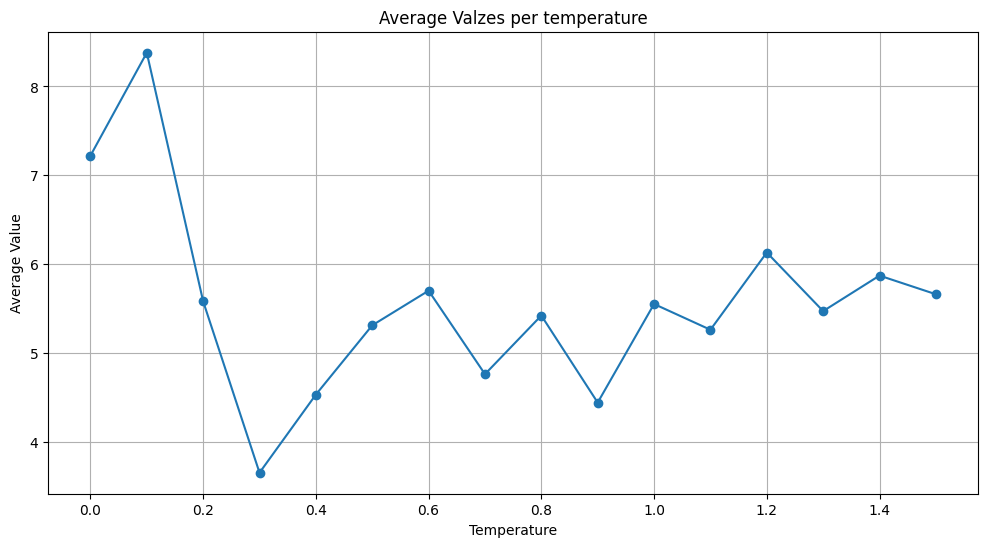

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(temperatures, averages, marker='o')
plt.title('Average Valzes per temperature')
plt.xlabel('Temperature')
plt.ylabel('Average Value')
plt.grid(True)
plt.show()

# Results Setup 4:

We see a indicated U-curve with relative high values on the extremely low temperature. Most of the values are in the range between 4 and 6 turns which is moderately stable.

The values <= 0,7 average on 5,76 turns,

The values > 0,7 average on 5,60 turns.

The model performs 2,8% better with temperatures <= 0,7 than the values > 0,7. This is below the 7,5% confidence threshold and can be attributed to chance.

H0 gets accepted,

H1 gets rejected.

Find the summary of all experiments in Chapter 1.